# Analysis of  model sensitivity to variations in storm temporal profile

## Description
Analysis of results of running 6hr duration, 1-in-100 year rainfall events through Hec-Ras model of Lin Dyke catchment. These include 8 idealised variations to FEH single peak profile, and the FEH single peak profile.

## Notes
The 'region' parameter in the first cell can be used to run this for different parts of the catchment

In [5]:
catchment_name = 'LinDyke' #LinDyke
methods_key ='Observed'
region = ''

In [6]:
import os
from pathlib import Path
from PIL import Image
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import sys

sys.path.append("../")
from my_functions import *

remove_little_values = True # Define whether to filter out values <0.1

# Specify strings relating to catchment
if catchment_name == 'LinDyke':
    catchment_name_str = "Resampled.Terrain" 
    minx, miny, maxx, maxy = 437000,  426500,  445500, 434300
    cell_size_in_m2 = 4
elif catchment_name == 'WykeBeck':
    catchment_name_str = "Terrain.wykeDEM" 
    minx, miny, maxx, maxy = 430004,  429978, 438660, 440996 
    cell_size_in_m2 = 1
    
# Create a bounding box (this is used in preparing the rasters)
bbox = box(minx, miny, maxx, maxy)    

In [7]:
# Set up ink to model directory and read in catchment shapefile
model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_name, methods_key)
landcover_directory = '../../../FloodModelling/{}Models/LandCoverData/'.format(catchment_name)

# Directory to save figures (create if it doesn't exist)
plots_directory = 'Outputs/Figs/{}Profiles/{}/'.format(methods_key, catchment_name)

# Check whether the specified path exists or not
isExist = os.path.exists(plots_directory)
# Create a new directory because it does not exist
if not isExist:
    os.makedirs(plots_directory)

### Read in land cover data and classifications

In [8]:
# Read in the data
landcover, out_meta = prepare_rainfall_scenario_raster(landcover_directory + "LandCover_clipped.tif".format(catchment_name, region),bbox, True)
# Convert the 1 and 6 values to 10 (for urban) and the rest to 11 (for non-urban).  
landcover_mod =  np.where(landcover==1, 10, landcover)
landcover_mod =  np.where(landcover_mod==6, 10, landcover_mod)
# Convert the rest of the classes to 11
for i in [1,2,3,4,5,7,8,9]:
    landcover_mod =  np.where(landcover_mod==i, 11, landcover_mod)

In [9]:
# Water landcover classification
landcover_water, out_meta = open_and_clip(landcover_directory + 'LandCover_water_classification.tif', bbox)
landcover_water_flat = landcover_water.flatten()

# Urban landcover classification
landcover_urban, out_meta = open_and_clip(landcover_directory + 'LandCover_urban_classification.tif', bbox)
landcover_urban_flat = landcover_urban.flatten()

### Plot the clusters

In [10]:
# fig,ax =plt.subplots(figsize=(50,20))
# img = Image.open("../CreateSyntheticRainfallEvents/{}Profiles/{}/6hr_100yrRP/PostLossRemoval/Profile_plots.PNG".format(methods_key, catchment_name))
# plt.axis('off')
# plt.imshow(img);

### Define the names of the method (in dictionary for different model runs)

In [11]:
methods_dict = {'Idealised': [ '6h_sp_c_0.5','6h_sp_fl_0.1', '6h_sp_fl_0.2', '6h_sp_fl_0.3', '6h_sp_fl_0.4',
                    '6h_sp_bl_0.6','6h_sp_bl_0.7','6h_sp_bl_0.8','6h_sp_bl_0.9'],
                'Observed':['6h_feh_singlepeak','6h_c1','6h_c8','6h_c15','6h_c3','6h_c11','6h_c10','6h_c9','6h_c13','6h_c6',
                 '6h_c2','6h_c12','6h_c14','6h_c4','6h_c7','6h_c5'], 
               'SinglePeak_Scaled':['6h_sp_+0%','6h_sp_+5%','6h_sp_+10%','6h_sp_+15%','6h_sp_+20%']}

# Alternative - Obesrved, sorted by intensity
# short_ids_by_intensity = ['6h_feh_singlepeak','6h_c1','6h_c5','6h_c15','6h_c14','6h_c3','6h_c7','6h_c10','6h_c6','6h_c13',
#  '6h_c2','6h_c4','6h_c9','6h_c12','6h_c8','6h_c11']

In [12]:
methods = methods_dict[methods_key]

### Read in summary results from Processing-2.ipynb script

In [13]:
cluster_results= pd.read_csv("Outputs/Data/{}Profiles/{}/{}allclusters_summary.csv".format(methods_key, catchment_name, region))

# Relationship between the number of flooded cells in urban and non-urban areas

27% of the catchment is classified as either urban or semi-urban.  

Changes to the extent, depth and velocity of flooding in these areas are the most important.  
Therefore, it is important to determine whether any of the rainfall scenarios result in a greater proportion of the flooding taking part in these urban areas.  

The plots below show:
* The relationship between the flooded area and the urban flooded area. There is a fairly consistent relationship across all the scenarios, with between 33 and 35% of the flooding being in urban areas. 
* The relationship between the percentage difference in flooded area between each scenario and the FEH single peak scenario in urban and non urban areas. This is also fairly consistent across the scenarios

In [14]:
cluster_results['%floodedarea_urban'] = round(cluster_results['UrbanFloodedArea']/cluster_results['FloodedArea']*100,2)
cluster_results['%_of_area_flooded'] =(cluster_results['FloodedArea']/29.589)*100
cluster_results['%_of_urban_area_flooded'] =(cluster_results['UrbanFloodedArea']/7.987)*100

In [15]:
# fig, axs = plt.subplots(figsize =(3,3))
# cluster_results[['Cluster_num', '%_of_urban_area_flooded']]
# axs.bar(cluster_results['Cluster_num'],cluster_results['%floodedarea_urban'], color = cluster_results['colour'] )
# axs.set_ylabel("% of flooded area \n which is urban")
# axs.xaxis.set_ticks(range(0,len(cluster_results['Cluster_num'])))
# axs.set_xticklabels(cluster_results['Cluster_num'], rotation=90, ha='right')
# plt.title("{}Profiles".format(methods_key));

In [16]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))
# # The urban flooded area as a percentage of the total area 
# axs[0].scatter(cluster_results['UrbanFloodedArea'], cluster_results['FloodedArea'], color = cluster_results['colour'])
# axs[0].set_xlabel('Urban Flooded area')
# axs[0].set_ylabel('Flooded area')
# # (cluster_results['UrbanFloodedArea']/cluster_results['FloodedArea'])*100
# # The difference between the flooded area from a method and single peak 
# axs[1].scatter(cluster_results['%Diff_FloodedArea_fromSP'], cluster_results['%Diff_UrbanFloodedArea_fromSP'],
#               color = cluster_results['colour'])
# axs[1].set_xlabel('% diff in urban flooded area between method and single peak')
# axs[1].set_ylabel('% diff in flooded area between \n method and single peak');

# colors = ['darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
# texts = ['F2','F1','C', 'B1', 'B2'] 
# patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.14, 0.5), loc='center', ncol=1, prop={'size': 9} )

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
# fig.suptitle("{}Profiles".format(methods_key));

# Relationship between the total flooded area & the rainfall scenario used
One difference that might be expected to arise from the use of different rainfall scenarios is a difference in the total area which is flooded.  

The plots below display the total flooded area generated by each of the rainfall scenarios, and the percentage difference between each scenario and the FEH single peak scenario.  
*  In the first row of plots, the scenarios are ordered by the minute at which the maximum rainfall intensity occurs, with the most front loaded profiles towards the left. 
*  In the second row, the scenarios are ordered by the maximum rainfall intensity, with the scenarios with the highest intensities on the left. 

This shows that there is variation in the total flooded area, with the extremes being one scenario having 9.4% more, and another having 7.2% less flooded area than the FEH single peak scenario. 

In [17]:
cluster_results['%Diff_FloodedArea_fromSP_formatted']=cluster_results['%Diff_FloodedArea_fromSP_formatted'].fillna('')
cluster_results['%Diff_UrbanFloodedArea_fromSP_formatted']=cluster_results['%Diff_UrbanFloodedArea_fromSP_formatted'].fillna('')

### Rename the profile names

In [18]:
if methods_key == 'Idealised':
    cluster_results['Cluster_num']=['C', 'FL1', 'FL2', 'FL3', 'FL4','BL6', 'BL7', 'BL8','BL9']
    ### Reorder to C in middle
    cluster_results = cluster_results.reindex([1,2,3,4,0,5,6,7,8])
    cluster_results.reset_index(inplace=True, drop=True)

### Plot the total flooded area (maximum flooded extent)

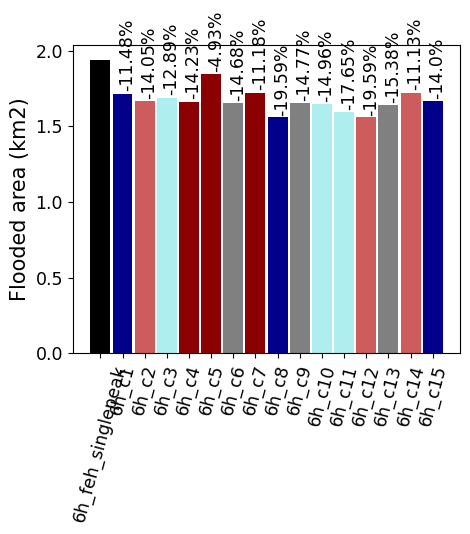

In [20]:
plot_totals_1plot(cluster_results, '', methods,  "{}Profiles".format(methods_key), plots_directory)
# plot_totals_3plots(cluster_results, '', methods,  "{}Profiles".format(methods_key), plots_directory)

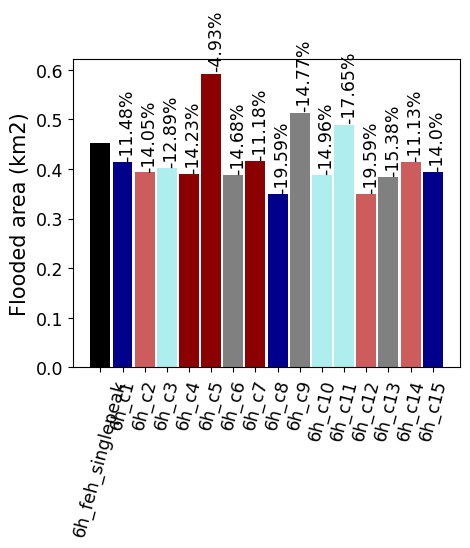

In [21]:
plot_totals_1plot(cluster_results, 'Urban', methods,  "{}Profiles".format(methods_key), plots_directory)
# plot_totals_3plots(cluster_results, 'Urban', methods,  "{}Profiles".format(methods_key), plots_directory)

### Plot the maximum peak intensity value, and the minute of max intensity against the flooded area

The relationship between the total flooded area and both the peak intensity and the minute of the peak intensity are also plotted for each scenario.

Additionally, the far left hand plot plots the relationship between the minute of peak intensity and the peak intensity. This verifies that there is no relationship between peak intensity and minute of peak intensity. 

This shows that there is a positive relationship between the total flooded area and the magnitude of the peak intensity, and a weaker positive relationship between the minute of the peak intensity and the total flooded area. 

In [22]:
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (12,3))
# scatter_plot_with_trend_line(axs[0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['MaxRainfallIntensityMinute'], 'Peak Intensity (mm)' , 'Minute of peak intensity', cluster_results['colour'], add_r2 = True)
# scatter_plot_with_trend_line(axs[1], methods, cluster_results['MaxRainfallIntensity'], cluster_results['FloodedArea'], 'Peak Intensity (mm)' , 'Total flooded area', cluster_results['colour'], add_r2 = True)
# scatter_plot_with_trend_line(axs[2], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['FloodedArea'], 'Minute of peak intensity' , 'Total flooded area',cluster_results['colour'], add_r2 = True)

# Relationship between flood severity & the rainfall scenario used

In addition to the difference which rainfall scenarios make to the total area which is flooded, it is also possible that the scenarios could influence the severity of the flooding in terms of the depth, velocity or hazard associated with the flooding.

### Boxplot summarising the number of cells with different depths/velocity values

#### Get one dataframe containing the values for all methods, one row per cell per method 
Also including the water class variable in that cell

In [23]:
each_cells_value = produce_df_of_cell_by_cell_values(model_directory, catchment_name_str, bbox, methods, landcover_water_flat, landcover_urban_flat)

#### Filter out cells with particular characteristics

In [24]:
each_cells_value_notwater = each_cells_value[each_cells_value['Water_class']==11]
each_cells_value_water = each_cells_value[each_cells_value['Water_class']==10]
each_cells_value_urban = each_cells_value[each_cells_value['urban_class']==10]

#### Plot histogram: log scale with first bin of width 10cm, and then each bin becoming subsequently 15% wider 

In [25]:
ls = [each_cells_value, each_cells_value_notwater, each_cells_value_water, each_cells_value_urban]
titles = ['AllCells', 'DryCells', 'WetCells', 'UrbanCells']

In [26]:
if methods_key == 'Observed':
    smallest_method = '6h_c1'
    largest_method = '6h_c7'
elif methods_key == 'Idealised':
    smallest_method = '6h_sp_fl_0.1'
    largest_method = '6h_sp_bl_0.9'    
elif methods_key == 'SinglePeak_Scaled':
    smallest_method = '6h_sp_+0%'
    largest_method = '6h_sp_+20%'        

In [27]:
df= each_cells_value
fl_01 = df[df['short_id']==smallest_method]
bl_09 = df[df['short_id']==largest_method]

### Test the percent difference between the most front and back loaded profiles including just those over certain depth/velocity values

In [28]:
# Filter to include just depths below 0.5
fl_01_over2 = fl_01[fl_01['Depth']>3]
bl_09_over2 = bl_09[bl_09['Depth']>3]
print(str((len(fl_01_over2)/len(bl_09_over2))*100))

99.97500000000001


In [29]:
fl_01_over2 = fl_01[fl_01['Velocity']>0.11]
bl_09_over2 = bl_09[bl_09['Velocity']>0.11]
(len(fl_01_over2)/len(bl_09_over2))*100

123.91791201852243

### Plot the histogram for the different filtered versions of the data

#### Depth and velocity plots together

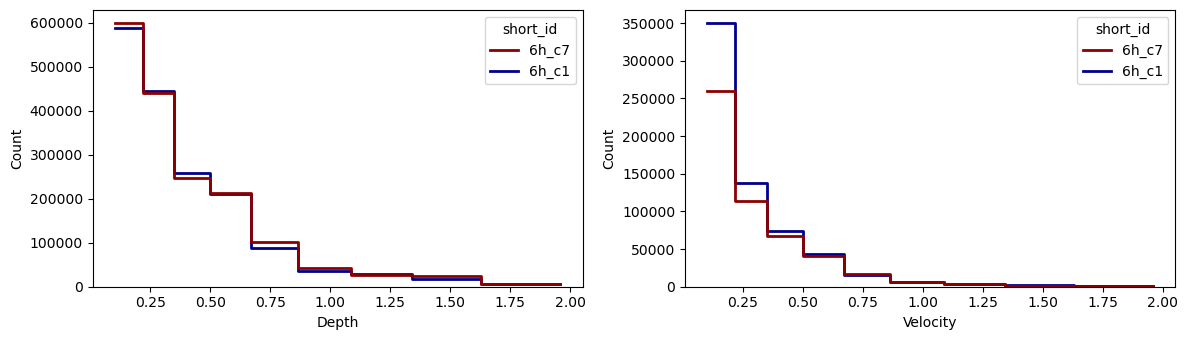

In [30]:
fig,axs=plt.subplots(ncols = 2, figsize = (12,3.5))
df = each_cells_value
# Get the fl01 and bl09 datasets separately
fl_01 = df[df['short_id']==smallest_method]
bl_09 = df[df['short_id']==largest_method]
bins = np.cumsum([0.1*1.14**i for i in np.arange (0.1,10.1,1)])

ls_depth =sns.histplot(ax=axs[0], data=pd.concat([bl_09,fl_01],axis=0), x='Depth', hue='short_id',stat='count',element = 'step', 
             linewidth=2,
             # fill =False,log_scale=False,bins=np.cumsum([0.1*1.15**i for i in np.arange (0.1,10.1,1)]),
             fill =False,log_scale=False,bins=bins,
             palette = ['darkred','darkblue']).get_lines()

ls_velocity = sns.histplot(ax=axs[1], data=pd.concat([bl_09,fl_01],axis=0), x='Velocity', hue='short_id',stat='count',element = 'step', 
             linewidth=2,
             # fill =False,log_scale=False,bins=np.cumsum([0.1*1.15**i for i in np.arange (0.1,10.1,1)]),
             fill =False,log_scale=False,bins=bins,
             palette = ['darkred','darkblue']).get_lines()
fig.tight_layout()
fig.savefig("{}/Histograms_Depth_and_Velocity.PNG".format(plots_directory,), bbox_inches='tight')

### Find the percentage difference between the two values for each bin

In [31]:
change_pcs_depth = []
for num in range(0,len(ls_depth[1].get_data()[1][:-1])):
    previous = ls_depth[0].get_data()[1][:-1][num]
    current = ls_depth[1].get_data()[1][:-1][num]
    change_percent = ((float(current)-previous)/previous)*100
    change_pcs_depth.append(change_percent)

previous_ls = []
current_ls = []
change_pcs_velocity = []
for num in range(0,len(ls_velocity[1].get_data()[1][:-1])):
    previous = ls_velocity[0].get_data()[1][:-1][num]
    current = ls_velocity[1].get_data()[1][:-1][num]
    previous_ls.append(previous)
    current_ls.append(current)
    change_percent = ((float(current)-previous)/previous)*100
    change_pcs_velocity.append(change_percent)    

In [32]:
# Final value is repeated (not sure why, but checked with counts, bin_edges = np.histogram(x, bins=3))
props_depth = (ls_depth[0].get_data()[1][:-1] /ls_depth[1].get_data()[1][:-1])*100
props_velocity = (ls_velocity[0].get_data()[1][:-1] /ls_velocity[1].get_data()[1][:-1])*100

# make labels
b = [f'[{i}-{j}m]' for i, j in zip(np.round(bins,1)[:], np.round(bins,1)[1:])] 

# Convert into a dataframe
df = pd.DataFrame({'label':b, 'depth': np.round(props_depth,1), 'velocity': np.round(props_velocity,1),
                  'change_pcs_depth': change_pcs_depth, 'change_pcs_velocity': change_pcs_velocity})

### Plot histogram alongside barchart with the percentage increase in flooded area from FL to BL

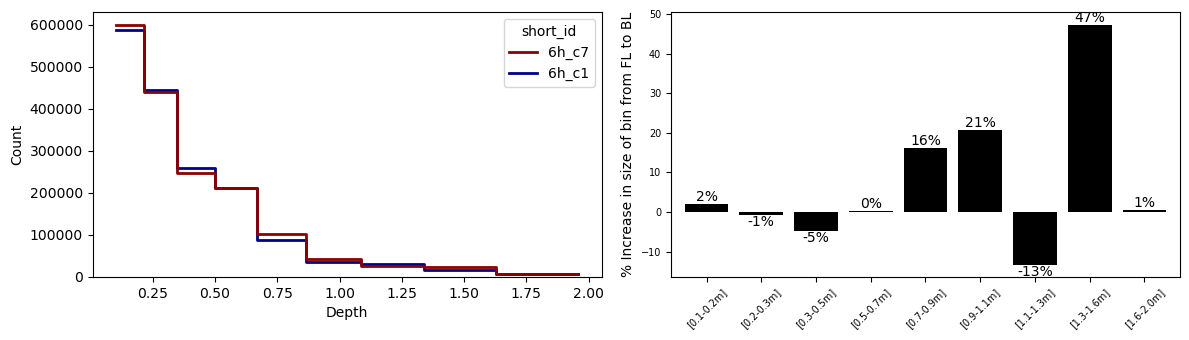

In [33]:
fig,axs=plt.subplots(ncols = 2, figsize = (12,3.5))
ls_depth =sns.histplot(ax=axs[0], data=pd.concat([bl_09,fl_01],axis=0), x='Depth', hue='short_id',stat='count',element = 'step', 
             linewidth=2,
             # fill =False,log_scale=False,bins=np.cumsum([0.1*1.15**i for i in np.arange (0.1,10.1,1)]),
             fill =False,log_scale=False,bins=bins,
             palette = ['darkred','darkblue']).get_lines()

# # y_pos = np.arange(len(df['change_pcs_depth']))
# y_pos = ls_depth[0].get_data()[0]
# xlocs, xlabs = plt.xticks(y_pos)
# xlocs=[i/2 for i in y_pos]
# # xlabs=[i/2 for i in range(0,len(df['change_pcs_depth']))]

# for i, v in enumerate(ls_depth[0].get_data()[1].tolist()[:-1]):
#     axs[0].text(xlocs[i+1], v*1.23, str(round(df["change_pcs_depth"][i],1)), 
#                 fontsize = 10, rotation =90)

df.plot(ax=axs[1],x='label', y='change_pcs_depth', kind='bar', legend=False, rot=45, width=0.8, fontsize=7, color='black')
axs[1].bar_label(axs[1].containers[0],fmt='%.f%%', label_type='edge')
axs[1].set_ylabel('% Increase in size of bin from FL to BL')
axs[1].set_xlabel('')
fig.tight_layout()
fig.savefig("{}/Histograms_Depth_With_%.PNG".format(plots_directory,), bbox_inches='tight')

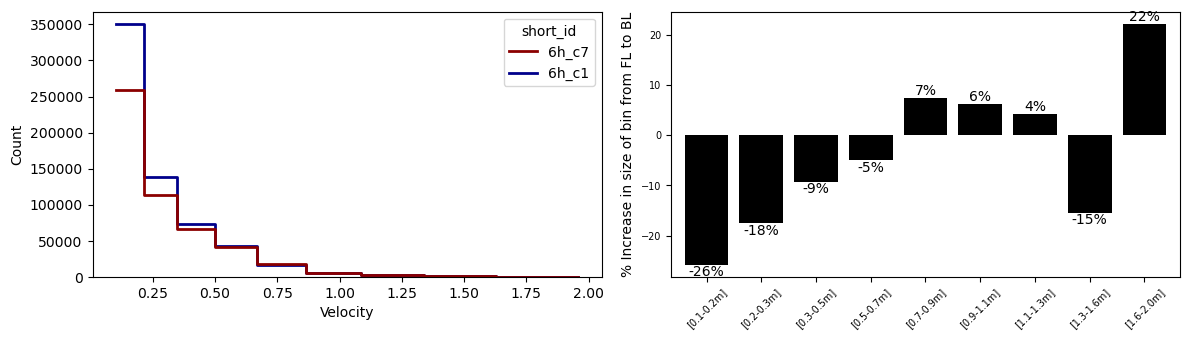

In [34]:
fig,axs=plt.subplots(ncols = 2, figsize = (12,3.5))
ls_depth =sns.histplot(ax=axs[0], data=pd.concat([bl_09,fl_01],axis=0), x='Velocity', hue='short_id',stat='count',element = 'step', 
             linewidth=2,
             # fill =False,log_scale=False,bins=np.cumsum([0.1*1.15**i for i in np.arange (0.1,10.1,1)]),
             fill =False,log_scale=False,bins=bins,
             palette = ['darkred','darkblue']).get_lines()

df.plot(ax=axs[1],x='label', y='change_pcs_velocity', kind='bar', legend=False, rot=45, width=0.8, fontsize=7, color='black')
axs[1].bar_label(axs[1].containers[0],fmt='%.f%%', label_type='edge')
axs[1].set_ylabel('% Increase in size of bin from FL to BL')
axs[1].set_xlabel('')
fig.tight_layout()
fig.savefig("{}/Histograms_Velocity_With_%.PNG".format(plots_directory,), bbox_inches='tight')

### Plot histogram alongside barchart with the proportion of the flooded cells in the BL profile found in the FL profile

In [35]:
# fig,axs=plt.subplots(ncols = 2, figsize = (12,3.5))
# ls_depth =sns.histplot(ax=axs[0], data=pd.concat([bl_09,fl_01],axis=0), x='Depth', hue='short_id',stat='count',element = 'step', 
#              linewidth=2,
#              # fill =False,log_scale=False,bins=np.cumsum([0.1*1.15**i for i in np.arange (0.1,10.1,1)]),
#              fill =False,log_scale=False,bins=bins,
#              palette = ['darkred','darkblue']).get_lines()

# df.plot(ax=axs[1],x='label', y='depth', kind='bar', legend=False, rot=45, width=0.8, fontsize=7, color='black')
# axs[1].bar_label(axs[1].containers[0],fmt='%.f%%', label_type='edge')
# axs[1].set_ylabel('% Increase in size of bin from FL to BL')
# axs[1].set_xlabel('');

### Plot the maximum peak intensity value against the flooded area

The relationship between the proportion of flooded cells in various depth/velocity/hazard categories and both the peak intensity and the minute of the peak intensity are also plotted for each scenario.

This shows that there is a positive, significant relationship between proportion of cells in the shallowest depth categogy, and a negative, signficant relationship between the proportion of cells in the deepest depth category and the magnitude of the peak intensity (i.e. the higher the peak intensity, the greater the proportion of cells have shallower flooding, and the fewer the proportion of cells have deeper flooding). COUNTER INTUITIVE??

The relationship between the proportion of cells in the deepest depth category and the minute of peak intensity is also significant, with higher proportions found at later minutes. The relationship with the lowest depth category is not significant.

In [36]:
# for x_var in ['MaxRainfallIntensity','MaxRainfallIntensityMinute' ]:
#     print(x_var)
#     for y_var in ['<=0.3m_propcells','0.3-0.6m_propcells','0.6-1.2m_propcells','>1.2m_propcells']:
#         m, b, r_value, p_value, std_err = stats.linregress(cluster_results[x_var], cluster_results[y_var])
#         print(y_var, 'r = ', round(r_value,2), ' p value = ', round(p_value,2))

In [37]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10,6))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
# scatter_plot_with_trend_line(axs[0,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['<=0.3m_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest depth cat',cluster_results['colour'],  add_r2 = True)
# scatter_plot_with_trend_line(axs[0,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['<=0.3m_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest depth cat',cluster_results['colour'],  add_r2 = True)

# scatter_plot_with_trend_line(axs[1,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['>1.2m_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nhighest depth cat', cluster_results['colour'], add_r2 = True)
# scatter_plot_with_trend_line(axs[1,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['>1.2m_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nhighest depth cat', cluster_results['colour'], add_r2 = True)

# fig.suptitle("Relationship between depth category and maximum rainfall intensity value and timing");

In [38]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10,6))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.6)
# scatter_plot_with_trend_line(axs[0,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['<=0.25m/s_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest velocity cat', cluster_results['colour'], add_r2 = True)
# scatter_plot_with_trend_line(axs[0,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['<=0.25m/s_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest velocity cat', cluster_results['colour'], add_r2 = True)

# scatter_plot_with_trend_line(axs[1,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['0.5-2m/s_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nhighest velocity cat',cluster_results['colour'],  add_r2 = True)
# scatter_plot_with_trend_line(axs[1,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['0.5-2m/s_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nhighest velocity cat',cluster_results['colour'],  add_r2 = True)
# fig.suptitle("Relationship between velocity category and maximum rainfall intensity value and timing");

### Relationship between hazard and maximum rainfall intensity value and timing

In [39]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10,6))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.55)
# scatter_plot_with_trend_line(axs[0,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['Low hazard_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest hazard cat',cluster_results['colour'],  add_r2 = True)
# scatter_plot_with_trend_line(axs[0,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['Low hazard_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest hazard cat',cluster_results['colour'],  add_r2 = True)

# scatter_plot_with_trend_line(axs[1,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['Extreme hazard_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nhighest hazard cat', cluster_results['colour'], add_r2 = True)
# scatter_plot_with_trend_line(axs[1,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['Extreme hazard_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nhighest hazard cat', cluster_results['colour'], add_r2 = True)

# fig.suptitle("Relationship between hazard and maximum rainfall intensity value and timing");

In [40]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10,6))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.55)
# scatter_plot_with_trend_line(axs[0,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['Significant hazard_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest hazard cat',cluster_results['colour'],  add_r2 = True)
# scatter_plot_with_trend_line(axs[0,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['Significant hazard_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest hazard cat',cluster_results['colour'],  add_r2 = True)

# scatter_plot_with_trend_line(axs[1,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['Moderate hazard_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nhighest hazard cat', cluster_results['colour'], add_r2 = True)
# scatter_plot_with_trend_line(axs[1,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['Moderate hazard_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nhighest hazard cat', cluster_results['colour'], add_r2 = True)

# fig.suptitle("Relationship between hazard and maximum rainfall intensity value and timing");

## Method leading to deepest/fastest flooding in each cell

This plot shows the number of cells for each method which have flooding which is deeper or faster than in any of the other methods.

In [41]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,7))  
# plot_worst_case_bars(axs[0], cluster_results, methods, 'WorstCaseDepth_ncells')
# plot_worst_case_bars(axs[1], cluster_results, methods,'WorstCaseVelocity_ncells')    

# Hydrographs from different points in catchment
Within Hec-Ras profile line are constructed at several points in the catchment (based on Megan's report; check logic on this). See below. 
<!-- At each of these points -->

In [42]:
# fig,ax =plt.subplots(figsize=(10,5))
# img = Image.open("../profilelines.PNG")
# plt.axis('off')
# plt.imshow(img);

In [43]:
# columns_obs = ['Time', '6h_sp_c_0.5','6h_sp_fl_0.1', '6h_sp_fl_0.2', '6h_sp_fl_0.3', '6h_sp_fl_0.4',
#           '6h_sp_bl_0.6','6h_sp_bl_0.7','6h_sp_bl_0.8','6h_sp_bl_0.9']

### Find the maximum values and the time at which these maximum values are recorded

In [44]:
# flow_timeseries = pd.read_csv(model_directory + "ProfileLines/{}/Flow_timeseries.csv".format('SheffieldBeck'))[columns_obs]

# # Create lists to store the maximum values and the times at which they occur
# peak_times = []
# max_vals = []
# mins_peak_from_start = []
# # Loop through each column and add a max value to the lists (can delete bit for NaNs once all data is fixed)
# for number, column in enumerate(flow_timeseries.columns[1:]):
#     max_row = flow_timeseries[flow_timeseries[column] == flow_timeseries[column].max()]
#     if len(max_row) == 0:
#         peak_times.append(np.nan)
#         max_vals.append(np.nan)
#         mins_peak_from_start.append(np.nan)
#     else:
#         peak_time = pd.to_datetime(max_row['Time'])[max_row['Time'].index[0]]
#         mins_peak_from_start_this_profile = (peak_time - pd.to_datetime(flow_timeseries['Time'][0])).total_seconds()/60
#         peak_times.append(peak_time)
#         mins_peak_from_start.append(mins_peak_from_start_this_profile)
#         max_vals.append(max_row[column][max_row[column].index[0]])

# # Remove NANs (for now)
# peak_times = [x for x in peak_times if str(x) != 'nan']        

## Flow - NB SHOULD REDO THESE NOW PROFILES HAVE BEEN RERAN
### Table of time to peak flow and the magnitude of peak flow for each profile
For Kipax Beck:  
There is a maximum difference between scenarios in peak flow intensity of 3.1 cumecs (so the largest peak flow is 93% higher than the smallest peak flow).    
There is a time difference of 280 minutes between arrivals of peak flows (so the an 174% change in the timing of the peak arrival). 

In [45]:
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (14,3), sharey=True)
# for axs_numb, profile_line in enumerate(['KippaxBeck', 'SheffieldBeck', 'LinDyke']):
#     flow_timeseries = pd.read_csv(model_directory + "ProfileLines/{}/Flow_timeseries.csv".format(profile_line))[columns_obs]
#     for number, column in enumerate(flow_timeseries.columns[1:]):
#         axs[axs_numb].plot(flow_timeseries[column], color = cluster_results['colour'][number])
#         axs[axs_numb].set_title(profile_line)
#         axs[axs_numb].set_xlabel('Minute')
#         axs[axs_numb].set_ylabel('Flow (cumecs)')
# # Legend
# colors = ['black','darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
# texts = ['FEH','F2','F1','C', 'B1', 'B2'] 
# patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.14, 0.5), loc='center', ncol=1, prop={'size': 9} )   ;

In [46]:
# df = pd.DataFrame({'profile':flow_timeseries.columns[1:], 'Time to peak flow (mins)':mins_peak_from_start,
#              'Peak flow intensity (cumecs)':max_vals})
# df = df.dropna()
# df.reset_index(inplace=True, drop=True)
# df.sort_values(by='Time to peak flow (mins)')

In [47]:
def get_change(current, previous):
    if current == previous:
        return 0
    try:
        return round((abs(current - previous) / previous) * 100.0,1)
    except ZeroDivisionError:
        return float('inf')

In [48]:
# print(get_change(df['Peak flow intensity (cumecs)'].min(),df['Peak flow intensity (cumecs)'].max()))
# print(get_change(df['Time to peak flow (mins)'].min(),df['Time to peak flow (mins)'].max()))
# print(df['Time to peak flow (mins)'].max() - df['Time to peak flow (mins)'].min())

### Depth (these are actaully for a point not profile line, so don't make sense entirely)
Moving downstream (from Kippax Beck -> Sheffield Beck -> Lin Dyke): 

* The peak flow reduces (suggesting in journey downstream some water is lost i.e. to ponding or storage somewhere (this water will later be released) [altho from SB to LD at the end of the period the..]
* The time to peak increases (i.e. the peak occurs later in the event) as it takes longer for the water to travel downstream

More front loaded profiles have an earlier peak, and also generally a lower peak. 

<!-- If storage areas are filled up earlier then this would cause flow to peak higher and earlier -->

To do: Create table of the time of the peak flow and calculate % difference in peak flow between different profiles


In [49]:
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (14,3), sharey=True)
# for axs_numb, profile_line in enumerate(['KippaxBeck', 'SheffieldBeck', 'LinDyke']):
#     depth_timeseries = pd.read_csv(model_directory + "ProfileLines/{}/Depth_Timeseries.csv".format(profile_line))[columns_obs]
#     for number, column in enumerate(depth_timeseries.columns[1:]):
#         axs[axs_numb].plot(depth_timeseries[column], color = cluster_results['colour'][number])
#         axs[axs_numb].set_title(profile_line)
# # Legend
# colors = ['black','darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
# texts = ['FEH','F2','F1','C', 'B1', 'B2'] 
# patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.14, 0.5), loc='center', ncol=1, prop={'size': 9} )   ;

### Velocity

In [50]:
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (14,3), sharey=True)
# for axs_numb, profile_line in enumerate(['KippaxBeck', 'SheffieldBeck', 'LinDyke']):
#     velocity_timeseries = pd.read_csv(model_directory + "ProfileLines/{}/Velocity_Timeseries.csv".format(profile_line))[columns_obs]
#     for number, column in enumerate(velocity_timeseries.columns[1:]):
#         axs[axs_numb].plot(velocity_timeseries[column], color = cluster_results['colour'][number])
# # Legend
# colors = ['black','darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
# texts = ['FEH','F2','F1','C', 'B1', 'B2'] 
# patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.14, 0.5), loc='center', ncol=1, prop={'size': 9} )   ; 

### 

### Individual plot for each scenario containing values for each profile line 

In [51]:
# colors_downstream = ['red', 'darkorange', 'gold']
# fig, axs = plt.subplots(nrows=4, ncols=4, figsize = (14,7), sharex=True, sharey=True)
# col_num =0
# for i in range(4):
#     for j in range(4):
#         column = flow_timeseries.columns[1:][col_num]
#         col_num+= 1
#         # Plot line for each profile line location
#         for axs_numb, profile_line in enumerate(['KippaxBeck', 'SheffieldBeck', 'LinDyke']):
#             flow_timeseries = pd.read_csv(model_directory + "ProfileLines/{}/Flow_Timeseries.csv".format(profile_line))[columns_obs]
#             axs[i,j].plot(flow_timeseries[column], color = colors_downstream[axs_numb])
#             axs[i,j].set_title(column)

In [52]:
# top = mpl.cm.get_cmap('Oranges_r', 128)
# bottom = mpl.cm.get_cmap('Blues', 128)
# newcolors = np.vstack((top(np.linspace(0, 1, 128)),
#                        bottom(np.linspace(0, 1, 128))))
# newcmp = mpl.colors.ListedColormap(newcolors, name='OrangeBlue')
# newcmp

In [53]:
# # Set up figure
# f = folium.Figure(width=500, height=500)

# # Create base map - location figures were from clat, clon, but wanted to create map before loop
# mapa = folium.Map(location=[53.768306874761016, -1.3756056884868098],zoom_start=12).add_to(f)
# folium.TileLayer(
#     tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
#     attr="No Base Map",
#     name="No Base Map",
#     show=True
# ).add_to(mapa)

# # Catchment boundary
# catchment_boundary_feature_group = FeatureGroup(name='Catchment boundary')
# catchment_boundary_feature_group.add_child(folium.GeoJson(data=catchment_gdf["geometry"], style_function=lambda x, 
#                                      fillColor='#00000000', color='Black': { "fillColor": '#00000000',"color": 'Black',}))

# # Add landcover data
# landcover_fps = ['../../../FloodModelling/LinDykeModels/Model_{}Profiles/6h_sp_bl_0.9/Depth (Max).Resampled.Terrain.tif'.format(methods_key),
#     '../../../FloodModelling/LinDykeModels/Model_{}Profiles/6h_sp_fl_0.1/Depth (Max).Resampled.Terrain.tif'.format(methods_key)]
# names = [ 'BL09', 'FL01']
# for number, landcover_fp in enumerate(landcover_fps):
#     xarray_dataarray = prep_for_folium_plotting(landcover_fp)
#     # Get coordinates needed in plotting
#     clat, clon = xarray_dataarray.y.values.mean(), xarray_dataarray.x.values.mean()
#     mlat, mlon = xarray_dataarray.y.values.min(), xarray_dataarray.x.values.min()
#     xlat, xlon = xarray_dataarray.y.values.max(), xarray_dataarray.x.values.max()
#     # Apply colormap
#     data  = ma.masked_invalid(xarray_dataarray.values)
#     xarray_dataarray.values = xarray_dataarray.values
 
# #     xarray_dataarray.values[(xarray_dataarray.values < 0.48337996)] = np.nan
# #     xarray_dataarray.values[(xarray_dataarray.values > 0.64252528)] = np.nan
#     # colored_data = colorize(data.data, cmap = mpl.cm.Blues)
#     data  = ma.masked_invalid(xarray_dataarray.values)
#     colored_data = colorize(data.data, cmap =newcmp)

#     # Add to map
#     feature_group1 = FeatureGroup(name=names[number])
#     feature_group1.add_child(folium.raster_layers.ImageOverlay(colored_data,
#                               [[mlat, mlon], [xlat, xlon]],
#                               opacity=0.8,interactive=True, popup=names[number]))
#     mapa.add_child(feature_group1)

# # Add layers to map
# mapa.add_child(catchment_boundary_feature_group)
# mapa.add_child(LayerControl("topright", collapsed = False))
# display(mapa)